In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

from IPython import display
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import os
import numpy as np
import errno
import torchvision.utils as vutils
from IPython import display
from matplotlib import pyplot as plt
import torch
import h5py
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from torch import nn, optim


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [0]:
# randomly sampling data, slow for some reason
f = h5py.File('/content/gdrive/My Drive/Colab Notebooks/human_matrix.h5', 'r')
expression = f['data']['expression']
num_samples = 10000
num_genes = 500
samples=np.sort(np.random.choice(expression.shape[0],num_samples,replace=False))
genes=np.sort(np.random.choice(expression.shape[1],num_genes,replace=False))
expression_small = expression[samples,:]
expression_small = expression_small[:,genes]

In [0]:
# np.save("/content/gdrive/My Drive/Colab Notebooks/expression_small",expression_small)
expression_small = np.load("/content/gdrive/My Drive/Colab Notebooks/expression_small.npy")

In [0]:
!ls "gdrive/My Drive/Colab Notebooks"

 expression_small.npy	  GAN		      human_matrix.h5
"expression_small'.npy"  'Generative Model'   pytorch


expression_small is a data matrix with rows being samples and columns being genes. Here, we generate test and training sets. We also simulate compressed measurements on the test set

In [0]:
# Create test/train set and standardize
## split test and train set
X_train, X_test = train_test_split(expression_small,test_size=0.2)

## for normalization, we have to remove genes with no expression
mask = np.sum(X_train,axis=0)>0
X_train = X_train[:,mask]
X_test = X_test[:,mask]

## setting the number of expressed genes
num_genes = X_train.shape[1]

## simulate taking linear composite measurements, don't need them for training data
## y_test will be used when reconstructing the whole gene expression data
measurements = 300
A = np.random.normal(size=(measurements,num_genes))
y_test = np.dot(A,X_test.T).T

## for BCELoss, input data must be [0,1) so we divide by max value
## standardize the data
X_train_std = np.std(X_train,axis=0)
X_train_mean = np.mean(X_train,axis=0)
X_max = np.amax(X_train,axis=0) ## will need this when reconstructing
# X_train = np.divide(X_train,X_max)
X_train = np.divide(X_train - X_train_mean,X_train_std)
# X_test = np.divide(X_test,X_max)
# X_test = np.divide(X_test - X_train_mean,X_train_std)
X_train = torch.from_numpy(X_train.astype(float))
X_test = torch.from_numpy(X_test.astype(float))
X_max = torch.from_numpy(X_max.astype(float)).cuda().float()
X_train_mean = torch.from_numpy(X_train_mean.astype(float)).cuda().float()
X_train_std = torch.from_numpy(X_train_std.astype(float)).cuda().float()


# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(X_train, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [0]:
## TEST CELL TO SEE IF WE STANDARDIZE Y THIS WORKS BETTER
# Create test/train set and standardize
## split test and train set
X_train, X_test = train_test_split(expression_small,test_size=0.2)

## for normalization, we have to remove genes with no expression
mask = np.sum(X_train,axis=0)>0
X_train = X_train[:,mask]
X_test = X_test[:,mask]

## setting the number of expressed genes
num_genes = X_train.shape[1]

## simulate taking linear composite measurements, don't need them for training data
## y_test will be used when reconstructing the whole gene expression data
measurements = 300
A = np.random.normal(size=(measurements,num_genes))
y_test = np.dot(A,X_test.T).T


## for BCELoss, input data must be [0,1) so we divide by max value
## standardize the data
# X_train_std = np.std(X_train,axis=0)
# X_train_mean = np.mean(X_train,axis=0)
X_max = np.amax(X_train,axis=0) ## will need this when reconstructing
X_min = np.amin(X_train,axis=0)
X_max_min = X_max - X_min
X_train = np.divide(X_train-X_min,X_max_min)
# X_test = np.divide(X_test,X_max)
# A = np.random.normal(size=(measurements,num_genes))
# y_test = np.dot(A,X_test.T).T
# X_test = np.divide(X_test - X_train_mean,X_train_std)
X_train = torch.from_numpy(X_train.astype(float))
X_test = torch.from_numpy(X_test.astype(float))
X_min = torch.from_numpy(X_min.astype(float)).cuda().float()
X_max_min = torch.from_numpy(X_max_min.astype(float)).cuda().float()


# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(X_train, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [0]:
X_train

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0006, 0.0000, 0.0000,  ..., 0.0004, 0.0025, 0.0000],
        [0.0289, 0.0002, 0.0000,  ..., 0.0161, 0.1074, 0.0193],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0002, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0007, 0.0000, 0.0000],
        [0.0207, 0.0000, 0.0000,  ..., 0.0167, 0.0679, 0.0225]],
       dtype=torch.float64)

Defining the GAN

In [0]:

class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = num_genes
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = num_genes
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [0]:
# torch.cuda.empty()
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [0]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 2000

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:

num_test_samples = 16
test_noise = noise(num_test_samples)

Train the GAN

In [0]:


# logger = Logger(model_name='VGAN', data_name='MNIST')

# for epoch in range(num_epochs):
# discriminator_error = []
# generator_error = []
for epoch in range(1000):
    print(epoch)
    # g_error_total = 0
    # d_error_total = 0
    for n_batch, real_batch in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        real_data = real_data.float()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach().float()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        ##adding logging
    #     g_error_total = g_error_total + g_error
    #     d_error_total = d_error_total + d_error
    # discriminator_error.append(d_error_total / 8000)
    # generator_error.append(g_error_total / 8000)
        # Log error
        # logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # # Display Progress
        # if (n_batch) % 100 == 0:
        #     display.clear_output(True)
        #     # Display Images
        #     # test_images = vectors_to_images(generator(test_noise)).data.cpu()
        #     # logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
        #     # Display status Logs
        #     logger.display_status(
        #         epoch, num_epochs, n_batch, num_batches,
        #         d_error, g_error, d_pred_real, d_pred_fake
        #     )
        # # Model Checkpoints
        # logger.save_models(generator, discriminator, epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
discriminator_error_num = [x.cpu().data.numpy() for x in discriminator_error]

In [0]:
generator_error_num = [x.cpu().data.numpy() for x in generator_error]


In [0]:
!pip install tensorboardx

     |████████████████████████████████| 194kB 6.6MB/s 


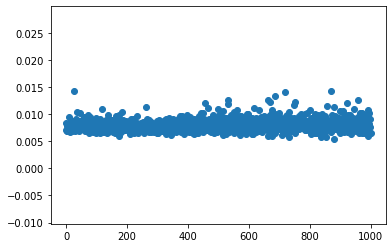

In [0]:
plt.scatter(epochs_y,generator_error_num)
plt.show()

In [0]:
#IGNORE
## generating random variable to feed generator
## requires_grad=True makes it so we can optimize it (I hope????)
z = Variable(torch.randn(100).cuda(), requires_grad=True)
generator.hidden0.requires_grad = False
generator.hidden1.requires_grad = False
generator.hidden2.requires_grad = False
generator.out.requires_grad = False





In [0]:
##IGNORE
# optim = torch.optim.Adam([z], lr=0.001)
optim = torch.optim.SGD([z], lr=0.00000000000001)
# samples = torch.matmul(A_tensor,generator(z))
criterion = nn.MSELoss()
A_tensor = torch.from_numpy(A.astype(float)).cuda().float()
y_tensor = torch.from_numpy(y_test.astype(float)).cuda().float()
samples = torch.matmul(A_tensor,generator(z))

In [0]:

# ## for BCELoss, input data must be [0,1) so we divide by max value
# ## standardize the data
# y_test_std = np.std(y_test,axis=0)
# y_test_mean = np.mean(y_test,axis=0)
# y_max = np.amax(y_test,axis=0) ## will need this when reconstructing
# # X_train = np.divide(X_train,X_max)
# y_test_norm = np.divide(y_test - y_test_mean,y_test_std)
# # X_test = np.divide(X_test,X_max)
# # X_test = np.divide(X_test - X_train_mean,X_train_std)
# y_test_std = torch.from_numpy(y_test_std.astype(float)).cuda().float()
# y_test_norm = torch.from_numpy(y_test_norm.astype(float))
# y_max = torch.from_numpy(y_max.astype(float)).cuda().float()
# y_test_mean = torch.from_numpy(y_test_mean.astype(float)).cuda().float()
# # X_train_std = torch.from_numpy(X_train_std.astype(float)).cuda().float()

Iterate through the test data and calculate the correlation coefficients between reconstructed gene expressions and actual gene expression by optimizing MSE(A*G(z),y) where A is the fixed, predetermined measurement matrix and y is compressed measurements.

In [0]:
import scipy
import math
loss_tracker = 0
total_count = 0
total_correlation = 0
# y_tensor.shape[0]
for i in range(0,100):
  loss_tracker = 0
  print(i)
  z = Variable(torch.randn(100).cuda(), requires_grad=True)
  generator.hidden0.requires_grad = False
  generator.hidden1.requires_grad = False
  generator.hidden2.requires_grad = False
  generator.out.requires_grad = False
  optim = torch.optim.SGD([z], lr=.0000000000000000000000001)
  criterion = nn.MSELoss()
  A_tensor = torch.from_numpy(A.astype(float)).cuda().float()
  y_tensor = torch.from_numpy(y_test.astype(float)).cuda().float()
  # y_tensor = y_test_norm.cuda().float()
  # samples = torch.matmul(A_tensor,generator(z))
  for epoch in range(0,2000):
    optim.zero_grad()
    # loss = criterion(torch.matmul(A_tensor,samples), y_tensor[0,:])
    # estimate = torch.matmul(A_tensor,samples)
    # loss = torch.mean((torch.matmul(A_tensor,generator(z)) - y_tensor[0,:])**2)
    loss = criterion(torch.matmul(A_tensor,(generator(z)*X_max_min)+X_min), y_tensor[i,:]) #CAN USE THIS
    # loss = criterion((torch.matmul(A_tensor,(generator(z)*X_train_std)+X_train_mean)*y_test_std)+y_test_mean, y_tensor[i,:])
    loss.backward(retain_graph=True)
    optim.step()
    if epoch % 200 == 0:
      print("=====")
      print(i)
      print(epoch)
      print(loss.item())
    loss_tracker = loss.item()
  corr = scipy.stats.pearsonr(generator(z).cpu().data.numpy(),X_test[i,:].data.numpy())
  if (math.isnan(corr[0])):
    total_count = total_count+0
  else:
    total_correlation = corr[0] + total_correlation
    total_count = total_count + 1
#print the average correlation between reconstructed gene expressiona and actual gene expressions
print(total_correlation/total_count)

0
=====
0
0
296605188096.0
=====
0
200
296605188096.0
=====
0
400
296605188096.0
=====
0
600
296605188096.0
=====
0
800
296605188096.0
=====
0
1000
296605188096.0
=====
0
1200
296605188096.0
=====
0
1400
296605188096.0
=====
0
1600
296605188096.0
=====
0
1800
296605188096.0
1
=====
1
0
2450732351488.0
=====
1
200
2450732351488.0
=====
1
400
2450732351488.0


KeyboardInterrupt: ignored

Ignore everything below here

In [0]:
import scipy
scipy.stats.pearsonr(generator(z).cpu().data.numpy(),X_test[0,:].data.numpy())

(0.5217260628822545, 4.1068472240463675e-36)

In [0]:
loss.grad

In [0]:
A_tensor.requires_grad

False

In [0]:
tester = generator(z) * X_max
tester.shape

torch.Size([498])

In [0]:
X_test.shape

torch.Size([2000, 498])

In [0]:
(generator(z)*X_max_min) + X_min

tensor([1.2244e+04, 1.5881e-22, 1.9100e+02, 0.0000e+00, 0.0000e+00, 2.4000e+01,
        2.3265e-30, 3.2000e+02, 2.9300e+02, 5.6000e+01, 4.3500e+02, 3.6500e+02,
        1.6500e+02, 0.0000e+00, 1.6100e+02, 0.0000e+00, 0.0000e+00, 9.8400e+03,
        9.7582e-33, 3.0000e+01, 9.9690e+03, 0.0000e+00, 6.8619e-30, 9.0600e+02,
        0.0000e+00, 4.1260e+03, 0.0000e+00, 2.5800e+03, 6.4857e+04, 0.0000e+00,
        0.0000e+00, 3.8743e-22, 2.2070e-27, 4.7977e+04, 0.0000e+00, 0.0000e+00,
        6.2599e-29, 2.6901e+04, 1.7662e-26, 0.0000e+00, 0.0000e+00, 1.0424e+04,
        1.8000e+01, 2.5210e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.9320e+03, 6.4058e+04, 8.2766e-20, 7.9690e+03, 4.4220e+03, 9.3000e+01,
        5.6560e+03, 0.0000e+00, 1.8266e+04, 7.9070e+03, 7.3873e+04, 2.9733e-32,
        1.8114e+04, 1.3398e+04, 0.0000e+00, 1.9750e+03, 8.2705e+04, 2.7990e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3770e-25, 0.0000e+00,
        0.0000e+00, 1.7485e-26, 1.9000e+